# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``dcm`` in the file ``dcopf.py``. 2) ACOPF is solved in pandapower.


Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from dcopf import dcm

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.6.3.post110.dev0+g38b94e9e
2.7.0


Import ADNES case

In [3]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee14_base.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee14_base.xlsx"...
Input file parsed in 0.2672 seconds.
System internal structure set up in 0.0498 seconds.


Set load as constant load.

In [4]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [5]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 2.237 p.u.


Text(0.5, 0, 'Time [s]')

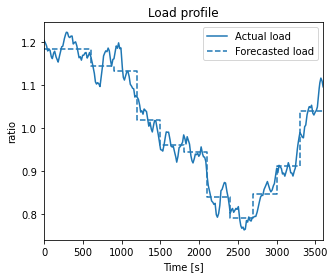

In [6]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 100
d_syn['s10'] = (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [7]:
# --- conversion ---
ssp = to_pandapower(ssa)

# add gen cost
gen_cost = np.array([
    [2, 0, 0, 3, 0.0, 40, 0],
    [2, 0, 0, 3, 0.0, 25, 0],
    [2, 0, 0, 3, 0.0, 30, 0],
    [2, 0, 0, 3, 0.0, 31, 0],
    [2, 0, 0, 3, 0.0, 32, 0],
    [2, 0, 0, 3, 0.0, 33, 0]
])

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.2367 seconds.
0: |F(x)| = 0.5605182162
1: |F(x)| = 0.006127943757
2: |F(x)| = 5.694809117e-06
3: |F(x)| = 5.725184216e-12
Converged in 4 iterations in 0.0083 seconds.
Power flow results are consistent. Conversion is successful.


True

**NOTE**: Alter the controllability of generator by modifying ``ssp.gen.controllable``

In [8]:
# set EV generator as uncontrollable
ssp.gen.controllable.iloc[4] = False

In [9]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_2,1,40.000,1.03,100.0,-40.0,15.0,1.0,False,True,None,True,10.0,50.0,NaN
1,PV_3,2,40.000,1.01,100.0,-10.0,15.0,1.0,False,True,None,True,10.0,50.0,NaN
2,PV_4,5,30.000,1.03,100.0,-6.0,10.0,1.0,False,True,None,True,10.0,100.0,NaN
3,PV_5,7,30.000,1.03,100.0,-6.0,10.0,1.0,False,True,None,True,10.0,50.0,NaN
4,PV_6,3,-1.000,1.01,100.0,0.0,0.0,1.0,False,True,None,False,-10.0,10.0,NaN
5,Slack_1,0,81.442,1.03,100.0,-50.0,100.0,1.0,True,True,None,True,50.0,300.0,NaN


Build DCOPF instance ``ssd``

In [10]:
ssd = dcm(ssp)

GSF is consistent.


Alter the EV generator type in ``ssd``

In [11]:
ssd.def_type(['gen6'])

True

Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [12]:
ssd.def_var(ptotal=ssp.load.p_mw.sum() / ssp.sn_mva,
            dpd_u=0.0, dpd_d=0.0, p_pre=[0.1, 0.5, 1, 0.147, -0.01, 0.5])
ssd.build_s()
ssd.mdls.optimize()

# access the vars value
gbres = []
for gen in ssd.gendict.keys():
    gbres.append(ssd.p_sch[gen].X)

pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ppres['gb'] = ssp.sn_mva * np.array(gbres)
ppres

pru_max length does not match Type II generator numbers!
prd_max length does not match Type II generator numbers!


Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 73 rows, 18 columns and 226 nonzeros
Model fingerprint: 0x8d80fc4c
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 71 rows and 13 columns
Presolve time: 0.01s
Presolved: 2 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2455000e+01   9.470000e-01   0.000000e+00      0s
       1    6.7237000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.723700000e+01


,p_mw,q_mvar,va_degree,vm_pu,gb
0,10.0,NaN,-1.233634,1.0,10.0
1,50.0,NaN,-1.952871,1.0,50.0
2,100.0,NaN,1.644258,1.0,100.0
3,14.7,NaN,-1.284473,1.0,14.7
4,-1.0,NaN,-2.574234,1.0,-1.0
5,50.0,NaN,0.000000,1.0,50.0


Test DCOPF with SFR of ``ssd``

In [13]:
# def. parameters
ssd.def_ps(c_ru=[], c_rd=[], rampu=[], rampd=[])
# # def. variables
ssd.def_var(ptotal=ssp.load.p_mw.sum() / ssp.sn_mva,
            dpd_u=0.0, dpd_d=0.0, p_pre=[],
            gen=['gen6'], pru_max=[0], prd_max=[0])

ssd.build()

ssd.mdl.optimize()

gbres = []
for gen in ssd.gendict.keys():
    gbres.append(ssd.p_sch[gen].X)
print(gbres)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 61 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x9201d7a3
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 59 rows and 13 columns
Presolve time: 0.00s
Presolved: 2 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2455000e+01   9.470000e-01   0.000000e+00      0s
       1    6.7237000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.723700000e+01
[0.1, 0.5, 1.0, 0.14700000000000002, -0.01, 0.5]


## Prepare

### Make link table

In [14]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl * ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,Slack_1,1.0,Slack_1,1,False,GENROU_1,ESST3A_2,TGOV1_1,BUS1,1.0,1.0,5,True
1,PV_2,1.0,PV_2,2,False,GENROU_2,EXST1_1,TGOV1_2,BUS2,1.0,1.0,0,True
2,PV_3,1.0,PV_3,3,False,GENROU_3,ESST3A_3,TGOV1_3,BUS3,1.0,1.0,1,True
3,PV_4,1.0,PV_4,6,False,GENROU_4,ESST3A_4,TGOV1_4,BUS6,1.0,1.0,2,True
4,PV_5,1.0,PV_5,8,False,GENROU_5,ESST3A_5,TGOV1_5,BUS8,1.0,1.0,3,True
5,PV_6,1.0,PV_6,4,EV_1,False,False,False,BUS4,0.5,0.5,4,False
6,PV_6,1.0,PV_6,4,EV_2,False,False,False,BUS4,0.5,0.5,4,False


### Define functions used in loop

In [15]:
# --- def functions ---
def get_pe(ssa, syg_idx, dg_idx, ssa_key2):
    """Get the active power (SynGen/DG) after TDS"""
    # SynGen
    pe_syg = ssa.SynGen.get(src='Pe', idx=syg_idx, attr='v')
    # DG
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # out
    pe = pd.DataFrame()
    pe['idx'] = syg_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'syg_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe.groupby('stg_idx').sum().pe.tolist()

def dp_calc(d_syn, idx_ed, intv_ed, ssa_p0_sum):
    """Calc SFR requirements ``dpd_u``and ``dpd_d``, and load forecasted value"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(ssa_p0_sum * (load_ci[0] - load_exp))
    load_u = abs(ssa_p0_sum * (load_ci[1] - load_exp))
    return load_u, load_d, load_exp

def get_dcres(ssd):
    """
    Get DCOPF resutlts from ``ssd``

    Returns
    ----------
    DataFrame
    
        The output DataFrame contains setpoints ``p_sch``,
        SFR Up/Dn capacity ``pru`` and ``prd``,
        and AGC Up/Dn participation factor: ``bu`` and ``bd``
    """
    # --- gather data --
    pru = []
    prd = []
    p_sch = []
    for gen in ssd.gendict.keys():
        p_sch.append(ssd.p_sch[gen].X)
        pru.append(ssd.p_ru[gen].X)
        prd.append(ssd.p_rd[gen].X)
    # --- build output table ---
    dcres = pd.DataFrame()
    dcres['stg_idx'] = ssd.gendata.gen_pp
    dcres['p_sch'] = p_sch
    dcres['pru'] = pru
    dcres['prd'] = prd
    dcres['bu'] = dcres['pru'] / dcres['pru'].sum()
    dcres['bd'] = dcres['prd'] / dcres['prd'].sum()
    dcres.fillna(0, inplace=True)
    return dcres
get_dcres(ssd)

,stg_idx,p_sch,pru,prd,bu,bd
name,,,,,,
gen1,PV_2,0.100,0.0,0.0,0.0,0.0
gen2,PV_3,0.500,0.0,0.0,0.0,0.0
gen3,PV_4,1.000,0.0,0.0,0.0,0.0
gen4,PV_5,0.147,0.0,0.0,0.0,0.0
gen5,PV_6,-0.010,0.0,0.0,0.0,0.0
gen6,Slack_1,0.500,0.0,0.0,0.0,0.0


## Define param

In [16]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.1
Ki = 0.1

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: DG.pmx: DPV profile, DG.pref0: setpoints

Notes for EV implementation:
- ``p_sch`` and ``p_aux`` for ``DG`` are assigned to ``DG`` considering ``gammap``
- In TDS, when generator reach gen limit, it will be vulnerble to crash

In [ ]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 0.98

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(3600): # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed, ssa_p0_sum)
        ssp.load['p_mw'] = ssa_p0 * load_exp * ssp.sn_mva
        ssp.load['q_mvar'] = ssa_q0 * load_exp * ssp.sn_mva

        # --- DCOPF, update gen limits after SFR ---
        ssd = dcm(ssp)
        # p_pre lenth = ssp.gen[ssp.gen.in_service * ssp.gen.controllable].shape[0]
        if end_time > 0:
            # TODO: actual ramp limits
            rampu = []
            rampd = []
            p_pre = get_pe(ssa, ssa_syg_idx, ssa_dg_idx, ssa_key2)
        else:
            rampu = [100] * ssd.gendata.shape[0]
            rampd = [100] * ssd.gendata.shape[0]
            # DCOPF results as the initial previous setpoints
            p_pre = list(ssp.res_gen.p_mw / ssp.sn_mva)

        # TODO: cost
        ssd.def_ps(c_ru=[], c_rd=[], rampu=[], rampd=[])

        # def sfr requirements and ev sfr limtis (p.u.)
        # TODO: Integrate EV; EV limits FROM EV; now set 0 to disable EV SFR
        ssd.def_var(ptotal=ssa_p0_sum * load_exp,
                    dpd_u=du, dpd_d=dd, p_pre=[],
                    gen=['gen6'], pru_max=[0], prd_max=[0])
        
        # build and solve the DC model
        ssd.build()
        res = ssd.mdl.optimize()

        # get resutls
        dcres = get_dcres(ssd)
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name':'stg_idx'}), 
                           right=dcres, on='stg_idx', how='left')
        ssp.gen.max_p_mw = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp.gen.min_p_mw = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            # save the previous dispatch results
            popf0 = ssp_res['p']
            # get the setpoints from TDS
            pe0 = get_pe(ssa, ssa_syg_idx, ssa_dg_idx, ssa_key2)

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)
        popf = ssp_res.p
        ssp_res.fillna(False, inplace=True)

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        
        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg.paux2 = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg.paux2 = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                           value=agc_dg.paux2.values)
        
        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = popf
        else:
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            # TODO: use pe0 as start point rather than popf0
            ssp_res['pref'] = popf + (popf - popf0) / n_step * idx_step
        # update setpoints
        cond_gov = ssp_res.controllable * ssp_res.gov_idx.astype(bool)
        ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                           attr='v', value=ssp_res.pref[cond_gov].values)
        # TODO: DG setpoints
        cond_dg = ssp_res.controllable * ssp_res.dg_idx.astype(bool)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                   attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                    value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                    value=ssa_q0 * d_syn['s10'].iloc[end_time])

    # RUN TDS
    ssa.TDS.config.tf = end_time
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")

GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0xb3cbf9b1
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [5e-03, 1e+01]
Presolve removed 51 rows and 9 columns
Presolve time: 0.00s
Presolved: 8 rows, 9 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0268421e+01   4.745375e-03   0.000000e+00      0s
       1    8.0268421e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.026842146e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0052 seconds.
0: |F(x)| = 0.5758162603
1: |F(x)| = 0.02959091614
2: |F(x)| = 4.682927244e-05
3: |F(x)| = 1.231706126e-10
Converged in 4 iterations in 0.

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0013 seconds.
TimeSeries does not contain any time stamp.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1187 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0845 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0849 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0868 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1155 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0856 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0715 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0865 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0702 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0739 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0977 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0704 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0779 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0706 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0767 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1203 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1173 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0694 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1252 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0900 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0861 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0889 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0763 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1312 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1258 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0701 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0717 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0711 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0867 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1196 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2214 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2233 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2518 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1719 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3255 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1294 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1368 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1849 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1520 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1174 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1121 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1564 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1606 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1675 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1511 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1319 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1319 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x4b58a219
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [5e-03, 1e+01]
Presolve removed 51 rows and 9 columns
Presolve time: 0.02s
Presolved: 8 rows, 9 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0362445e+01   4.930324e-03   0.000000e+00      0s
       1    8.0362445e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds (0.00 work units)
Optimal objective  8.036244526e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0775 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1185 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1312 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1282 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1364 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1529 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1402 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1724 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2111 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3359 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3293 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1591 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1737 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1618 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1796 seconds.


  0%|          | 0/100 [00:01<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1339 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1143 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1321 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1202 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1203 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0943 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0921 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0900 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1575 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0911 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1297 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1233 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1507 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1475 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1244 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4526 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4350 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0791 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0859 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0778 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1524 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0797 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0837 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0878 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0936 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0852 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1037 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0832 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0820 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1620 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0799 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0818 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0831 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0809 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0868 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1343 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0959 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1160 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0908 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0914 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0842 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0890 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0888 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1467 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0889 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0905 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0942 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0825 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0893 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0845 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0826 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0885 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1190 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0981 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1250 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1163 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1190 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1232 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1214 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0836 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1032 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0917 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1547 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0890 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1219 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0854 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1147 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0xf1a33e3e
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [7e-03, 1e+01]
Presolve removed 51 rows and 9 columns
Presolve time: 0.01s
Presolved: 8 rows, 9 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7393655e+01   7.353917e-03   0.000000e+00      0s
       1    7.7393655e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.739365539e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2401 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1579 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1545 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1504 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1037 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1112 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1337 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1518 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1477 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1490 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0936 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1495 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1874 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1490 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1482 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1454 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1258 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1012 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1170 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0936 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0886 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1572 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1184 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0952 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1169 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0904 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1242 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0913 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0927 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1229 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1161 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0929 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1619 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1288 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0952 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1568 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1365 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1340 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1377 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1329 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1291 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1356 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1540 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1012 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0914 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0929 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1169 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1111 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0925 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0936 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1177 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1284 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1082 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0921 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1110 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1196 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1177 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1174 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1248 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1098 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1566 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1177 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x4a6f6939
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [1e-02, 1e+01]
Presolve removed 52 rows and 9 columns
Presolve time: 0.01s
Presolved: 7 rows, 9 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9901575e+01   1.265224e+00   0.000000e+00      0s
       2    7.6550753e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.655075331e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1611 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1615 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1599 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1644 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1307 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1160 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1235 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1209 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1425 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1402 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1298 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1336 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1301 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1325 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1283 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1175 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1318 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1228 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1185 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1081 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1143 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1138 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1167 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1212 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1402 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1301 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1167 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1241 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1208 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1145 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1345 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1312 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1708 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1365 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1220 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1536 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1281 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1213 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1494 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1341 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1294 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1237 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1361 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1320 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1169 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1082 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4649 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.4597 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2559 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1194 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1169 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1161 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1135 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1111 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1080 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1264 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1260 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1269 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1232 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1237 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1138 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1163 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1259 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1203 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1173 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1080 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1241 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1025 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1260 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1557 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1145 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1112 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1210 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1182 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1213 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1867 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1319 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1113 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1110 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1228 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1194 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1098 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1012 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0981 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1573 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1112 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1012 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0945 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1536 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x604bbd65
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [7e-03, 1e+01]
Presolve removed 52 rows and 9 columns
Presolve time: 0.01s
Presolved: 7 rows, 9 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3574262e+01   1.008692e+00   0.000000e+00      0s
       2    6.8704884e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.870488426e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2117 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1544 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1417 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1449 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1639 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1080 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1512 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1503 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1246 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1161 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1314 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1236 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1303 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1260 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1340 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1187 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1243 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1688 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1580 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1330 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1630 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1376 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1295 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1169 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1348 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1279 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1112 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1250 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1234 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1143 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1110 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1523 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1866 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1114 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1280 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1007 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1120 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1150 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1356 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1158 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1266 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1197 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1209 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1228 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1301 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1307 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1289 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1037 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1336 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1204 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1180 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1295 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1184 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1149 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1025 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1193 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1143 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1025 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1500 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1160 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1190 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1177 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1360 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1187 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1080 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1076 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1150 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1084 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1116 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0xf377a01a
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [5e-03, 1e+01]
Presolve removed 52 rows and 9 columns
Presolve time: 0.01s
Presolved: 7 rows, 9 columns, 22 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0205872e+01   8.717288e-01   0.000000e+00      0s
       2    6.4541046e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.454104607e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2260 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1565 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1575 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1632 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1239 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2135 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1185 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1155 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1254 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1585 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1311 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0944 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0981 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1322 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1058 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1271 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1219 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1484 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1248 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1130 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1082 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1157 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1098 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1292 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1194 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1198 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1238 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1212 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1280 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1196 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1114 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1184 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1016 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1072 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1054 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1268 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1167 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1129 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1243 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1273 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1025 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1224 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1139 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1071 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1317 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1334 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1164 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1122 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2183 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1188 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1309 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1199 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1204 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1235 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1284 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1202 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1235 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1303 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2323 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1301 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1112 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1229 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1032 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1105 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1173 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1061 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1120 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1121 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1333 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1753 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1171 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1243 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0963 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1040 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1213 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1230 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1053 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1209 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1408 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1043 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1098 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1167 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1299 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1617 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1168 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1339 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1201 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1232 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1230 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1331 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x3d83da1c
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [5e-03, 1e+01]
Presolve removed 53 rows and 9 columns
Presolve time: 0.01s
Presolved: 6 rows, 9 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9334174e+01   8.371812e-01   0.000000e+00      0s
       2    6.3495009e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.349500861e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1659 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1504 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1488 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1315 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1067 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1349 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1042 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1331 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1118 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1049 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1120 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1212 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1187 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1252 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1334 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1025 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1255 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1303 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1082 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1576 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1079 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1181 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1088 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1870 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1560 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1580 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1144 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1637 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1232 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1821 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1277 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1137 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1125 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1301 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1549 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1490 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1195 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2590 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1292 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1059 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1224 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0965 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1112 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1021 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1189 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1155 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1246 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1453 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1325 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2624 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1620 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1146 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1238 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1147 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1312 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1319 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1007 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1192 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1055 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1132 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1311 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2151 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2016 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1452 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0946 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1387 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0951 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0968 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1141 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1143 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1132 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1007 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2581 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1628 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1520 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1589 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0985 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1481 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1541 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0997 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1611 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1398 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1508 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1121 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1575 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1945 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1657 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1560 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2468 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1586 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1690 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1591 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0955 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0959 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0979 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0934 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1009 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0931 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0959 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0948 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0943 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0966 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0939 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0987 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0952 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0930 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1003 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0999 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0962 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1064 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1462 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0993 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1186 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0960 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x92999bad
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [6e-03, 1e+01]
Presolve removed 53 rows and 9 columns
Presolve time: 0.00s
Presolved: 6 rows, 9 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3442549e+01   6.029719e-01   0.000000e+00      0s
       2    5.6425058e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.642505821e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1451 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1522 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1371 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1394 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1140 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1466 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1300 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1295 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1051 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1476 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1575 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1505 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1280 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1104 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1185 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1068 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1297 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1645 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3215 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3225 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1655 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1291 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1109 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1020 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1278 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1685 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1531 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1131 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2895 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1412 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2592 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1531 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1464 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1308 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1307 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1334 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1321 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1212 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1635 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1285 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1287 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1611 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1526 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1455 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1498 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1545 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1470 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1901 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1166 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1625 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1163 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1327 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0973 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1002 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1335 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1226 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2247 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1128 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1244 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1124 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2362 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1601 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1554 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1057 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1107 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1397 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1312 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1000 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1396 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1489 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1160 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1039 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1108 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1097 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1177 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1279 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2593 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1458 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1090 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1159 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1010 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1373 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1056 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1081 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1744 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1156 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1908 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1214 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1022 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1437 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1142 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1052 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1465 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1119 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1493 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1237 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1297 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1225 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1516 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1444 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2295 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1099 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1227 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1596 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1154 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1505 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1030 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1153 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1302 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1940 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1781 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1579 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1631 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2007 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1515 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1304 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1600 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1286 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1851 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1048 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1415 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1047 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1014 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3255 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1590 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1319 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0994 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0991 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1013 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0959 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0996 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1026 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1065 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1019 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1041 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1011 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1015 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1205 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0958 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1044 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1060 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1377 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1155 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1242 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1881 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2255 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1608 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1684 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1585 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1648 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1923 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1561 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1604 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1533 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1244 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1074 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1413 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1095 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1284 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1669 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1217 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1165 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1075 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1101 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1031 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1326 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1091 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0762 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x10a69323
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [4e-03, 1e+01]
Presolve removed 53 rows and 9 columns
Presolve time: 0.02s
Presolved: 6 rows, 9 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0775434e+01   4.940990e-01   0.000000e+00      0s
       2    5.3224521e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.03 seconds (0.00 work units)
Optimal objective  5.322452050e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2861 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2029 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3631 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2265 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1926 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1610 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3286 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3228 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1111 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1267 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2290 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1199 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1127 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0980 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1231 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1006 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1123 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1070 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1077 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1282 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1086 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1005 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1241 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1126 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.5017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1587 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1473 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1162 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1237 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0969 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0943 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1346 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1631 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1334 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2134 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1489 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1251 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1034 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1546 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1087 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1211 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0964 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1102 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2179 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1274 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1262 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1194 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1136 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1253 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1113 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1063 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1028 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1133 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1038 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1790 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1354 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0972 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0742 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0721 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0681 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0785 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0865 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0839 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0902 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2541 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0905 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0807 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0861 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0871 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0764 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0794 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0765 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0772 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0768 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0808 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0793 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0789 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1036 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0769 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0788 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0822 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0761 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0740 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0752 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0760 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1516 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0872 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0720 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0747 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0953 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0921 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0905 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0626 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0773 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0922 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1069 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0823 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0758 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0801 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0880 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0741 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0732 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0804 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0716 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0821 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0735 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0710 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0774 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0912 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1519 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0800 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0932 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0833 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1062 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0718 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0746 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0784 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0714 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0700 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0705 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0861 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1311 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0736 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0813 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0766 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0795 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0727 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0731 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0792 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0755 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0751 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1650 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0835 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0816 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1037 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0814 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0738 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0709 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0723 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0725 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0749 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0695 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0712 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0745 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0707 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0756 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0748 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0903 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0729 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0728 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0713 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0730 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0896 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0988 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0703 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0782 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0802 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0847 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1570 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0945 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0857 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1100 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0770 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0689 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0914 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1018 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0722 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1249 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1754 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1193 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1208 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1418 seconds.
GSF is consistent.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 59 rows, 18 columns and 214 nonzeros
Model fingerprint: 0x9ccd3bba
Coefficient statistics:
  Matrix range     [4e-04, 1e+00]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e-02, 3e+00]
  RHS range        [7e-03, 1e+01]
Presolve removed 53 rows and 9 columns
Presolve time: 0.01s
Presolved: 6 rows, 9 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3854236e+01   6.203800e-01   0.000000e+00      0s
       2    5.6919083e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.691908278e+01


/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/jinningwang/Documents/work/miniconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1679 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1456 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1796 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3445 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2288 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2132 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1771 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1981 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1514 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1916 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2358 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.3323 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.2386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1602 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1256 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1330 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1273 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1152 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1176 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0984 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0971 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1035 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1241 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1085 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1322 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1012 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1246 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1225 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1245 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1080 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1148 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1411 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1502 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1222 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0995 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1486 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1531 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1178 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1207 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1342 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1272 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1588 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1115 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0897 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1106 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1288 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1145 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1591 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1586 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0989 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0780 seconds.


In [ ]:
color=['tab:blue', 'tab:orange', 'tab:green',
       'tab:red', 'tab:purple']
right=end_time

fig_gen, ax_gen = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

yheader=['GEN 1', 'GEN 2', 'GEN 3', 'GEN 4', 'GEN 5']

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                   yheader=yheader, color=color,
                   legend=True, show=False, right=right,
                   title=r'Generation (solid: pout; dash: pref)',
                   ylabel='p.u.',
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                   linestyles=['--'],
                   color=color,
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                linestyles=['-'],
                yheader=yheader, color=color,
                legend=False, show=False, right=right,
                title=r'AGC power',
                ylabel='p.u.',
                fig=fig_gen, ax=ax_gen[0, 1])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

font = {'family' : 'TimesNewRoma',
        'weight' : '1',
        'size'   : 12}

plt.rc('font', **font)

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 1],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 1].set(xlabel='Deviation [p.u.]', ylabel='')